In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [2]:
''' Возьмем простые данные - n-мерное изотропное нормальное распределение N(0, I_d) '''

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def your_data_utils(x):
    mu1 = np.ones_like(x) * 2.0
    mu2 = np.ones_like(x) * -2.0

    def logp_mix(z):
        z = np.asarray(z)
        l1 = -0.5 * np.dot(z - mu1, z - mu1)
        l2 = -0.5 * np.dot(z - mu2, z - mu2)
        m = max(l1, l2)
        return m + np.log(np.exp(l1 - m) + np.exp(l2 - m))

    def grad_logp_mix(z):
        z = np.asarray(z)
        g1 = z - mu1
        g2 = z - mu2
        l1 = np.exp(-0.5 * g1 @ g1)
        l2 = np.exp(-0.5 * g2 @ g2)
        w1 = l1 / (l1 + l2)
        w2 = 1 - w1
        return w1 * g1 + w2 * g2

    return logp_mix, grad_logp_mix

In [3]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

def acf(x, maxlag=200):
    x = x - x.mean()

    ac = np.correlate(x, x, mode="full")
    ac = ac[len(ac)//2:]
    
    return ac[:maxlag] / ac[0]

In [4]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [5]:
def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):

        mu = x + step * grad_logp(x)
        prop = mu + rng.normal(0, np.sqrt(2*step), size=d)

        # q(prop|x)
        def logq(y, x_from):
            m = x_from + step * grad_logp(x_from)
            diff = y - m
            return -0.5 * np.dot(diff, diff) / (2*step)

        log_alpha = (
            logp(prop) - logp(x)
            + logq(x, prop)
            - logq(prop, x)
        )

        if np.log(rng.uniform()) < log_alpha:
            x = prop
            accept += 1

        chain[t] = x

    return chain, accept / steps

In [ ]:
print("Изотропное нормальное распределение")

d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

mala_step = 0.05
mh_scale = 0.4

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)


mh_post = mh_chain[burn:]
mala_post = mala_chain[burn:]

mh_ess = [ess(mh_post[:, i]) for i in range(d)]
mala_ess = [ess(mala_post[:, i]) for i in range(d)]

print("MH acceptance rate:", mh_acc)
print("MALA acceptance rate:", mala_acc)
print("Median ESS MH:", np.median(mh_ess))
print("Median ESS MALA:", np.median(mala_ess))

gaussian_results = {
    'mh_chain': mh_post,
    'mala_chain': mala_post,
    'mh_acc': mh_acc,
    'mala_acc': mala_acc,
    'mh_ess': np.median(mh_ess),
    'mala_ess': np.median(mala_ess)
}

Изотропное нормальное распределение N(0, I_d)
MH acceptance rate: 0.5414
MALA acceptance rate: 0.9906
Median ESS MH: 557.439382191556
Median ESS MALA: 643.0010656730451


In [12]:
print("Смесь двух гауссианов")

logp_orig = logp
grad_orig = grad_logp

logp, grad_logp = your_data_utils(x0)

x0 = np.zeros(d)

mh_chain, mh_acc = mh(x0, steps, scale=mh_scale)
mala_chain, mala_acc = mala(x0, steps, step=mala_step)

mh_post = mh_chain[burn:]
mala_post = mala_chain[burn:]

mh_ess = [ess(mh_post[:, i]) for i in range(d)]
mala_ess = [ess(mala_post[:, i]) for i in range(d)]

print("MH acceptance rate:", mh_acc)
print("MALA acceptance rate:", mala_acc)
print("Median ESS MH:", np.median(mh_ess))
print("Median ESS MALA:", np.median(mala_ess))

mixture_results = {
    'mh_chain': mh_post,
    'mala_chain': mala_post,
    'mh_acc': mh_acc,
    'mala_acc': mala_acc,
    'mh_ess': np.median(mh_ess),
    'mala_ess': np.median(mala_ess)
}

Смесь двух гауссианов
MH acceptance rate: 0.5420333333333334
MALA acceptance rate: 0.3327333333333333
Median ESS MH: 530.1726952635615
Median ESS MALA: 185.95779109685515


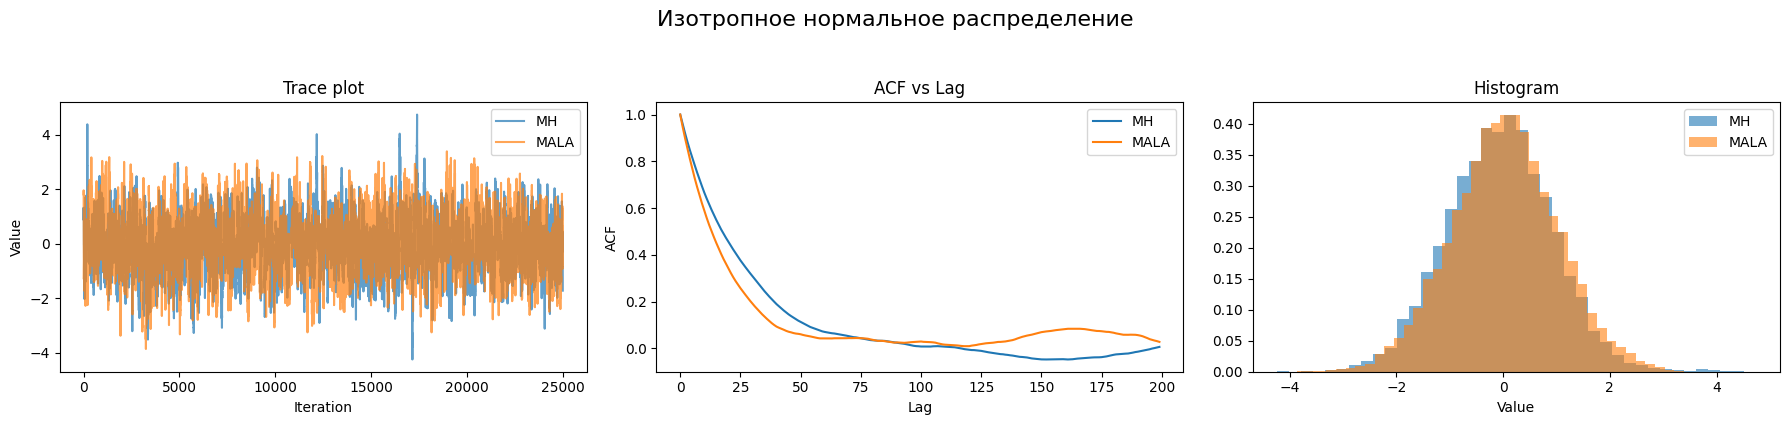

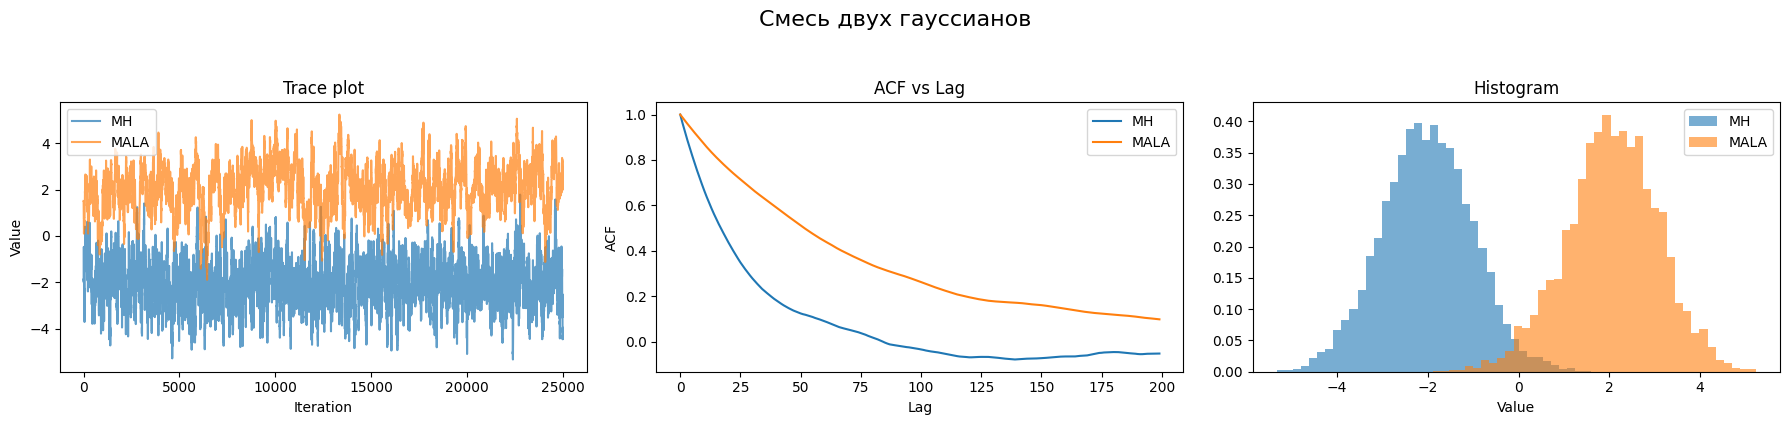

In [13]:
import matplotlib.pyplot as plt

def plot_experiment(results, title, dim=0):
    mh = results['mh_chain'][:, dim]
    mala = results['mala_chain'][:, dim]

    fig = plt.figure(figsize=(18,4))
    fig.suptitle(title, fontsize=16, y=1.05)

    # Trace plot
    plt.subplot(1, 3, 1)
    plt.plot(mh, label='MH', alpha=0.7)
    plt.plot(mala, label='MALA', alpha=0.7)
    plt.title("Trace plot")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()

    # ACF
    plt.subplot(1, 3, 2)
    plt.plot(acf(mh), label='MH')
    plt.plot(acf(mala), label='MALA')
    plt.title("ACF vs Lag")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.legend()

    # Гистограмма
    plt.subplot(1, 3, 3)
    plt.hist(mh, bins=40, density=True, alpha=0.6, label='MH')
    plt.hist(mala, bins=40, density=True, alpha=0.6, label='MALA')
    plt.title("Histogram")
    plt.xlabel("Value")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_experiment(gaussian_results, "Изотропное нормальное распределение")
plot_experiment(mixture_results, "Смесь двух гауссианов")